In [16]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, ZeroPadding2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [17]:
base_path = '/kaggle/input/dataset-180-per-class'
data_dir = os.path.join(base_path, 'to_train')

dataset_path = os.path.join(data_dir, 'preprocessed')
train_path = os.path.join(data_dir, 'training')
valid_path = os.path.join(data_dir, 'validation')
testing_path = os.path.join(data_dir, 'testing')

In [18]:
img_height, img_width = 224, 224
validation_split=0.2

In [19]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset='training',
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
)

Found 3600 files belonging to 20 classes.
Using 2880 files for training.


In [20]:
validate_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    seed=123,
    subset='validation',
    label_mode='categorical',
    image_size=(img_height, img_width),
)

Found 3600 files belonging to 20 classes.
Using 720 files for validation.


In [21]:
def residual_block(x, filters, stride=1, use_projection=False):
    identity = x

    # First convolution layer in the block
    x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer in the block
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution layer in the block
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # Projection shortcut for identity
    if use_projection:
        identity = Conv2D(filters * 4, kernel_size=(1, 1), strides=stride, padding='valid')(identity)
        identity = BatchNormalization()(identity)

    # Adding the identity (skip connection) to the output
    x = Add()([x, identity])
    x = ReLU()(x)

    return x

In [22]:
def build_resnet101(dropout, input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)
    
    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(22):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    if dropout != 0:
        x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet101')

    return model

In [23]:
def build_resnet50(dropout, input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(5):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    if dropout != 0:
        x = tf.keras.layers.Dropout(dropout)(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet50')

    return model

In [24]:
def print_history(history, epoch):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.axis([0, epoch, 0, max(history.history['val_accuracy'])])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.axis([0, epoch, 0, max(history.history['val_loss'])])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    plt.show()

In [25]:
output_dir = '/kaggle/working/'
model_resnet101 = os.path.join(output_dir, 'resnet101_180.h5')
model_resnet50 = os.path.join(output_dir, 'resnet50_180.h5')

save_model_101 = tf.keras.callbacks.ModelCheckpoint(
   model_resnet101,
   monitor='val_accuracy', 
   save_best_only=True, 
   mode='max', 
   verbose=1
)
save_model_50 = tf.keras.callbacks.ModelCheckpoint(
   model_resnet50,
   monitor='val_accuracy', 
   save_best_only=True, 
   mode='max', 
   verbose=1
)

In [26]:
def cross_val(model, n_splits, epochs):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    epoch = epochs//n_splits
    
    histories = []

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_one_hot[train_index], y_one_hot[val_index]

        # Latih model pada setiap fold
        history = model.fit(X_train, y_train, epochs=epoch, validation_data=(X_val, y_val))
        histories.append(history.history)

        # Evaluasi model pada fold saat ini jika diperlukan
        model.evaluate(X_val, y_val)
    return model, histories

In [27]:
def build_101(batch_size, epoch, learning_rate, dropout):
    resnet101 = build_resnet101(dropout=dropout)
    resnet101.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    history = resnet101.fit(
      train_gen,
      epochs=epoch,
      validation_data=validate_gen,
      batch_size=batch_size,
      callbacks=[save_model_101]
    )
    print_history(history, epoch)
    return resnet101

In [28]:
def build_50(batch_size, epoch, learning_rate, dropout):
    model = build_resnet50(dropout=dropout)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
      train_gen,
      epochs=epoch,
      validation_data=validate_gen,
      batch_size=batch_size,
      callbacks=[save_model_50]
    )
    print_history(history, epoch)
    return model

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 3.6407 - accuracy: 0.0601
Epoch 1: val_accuracy improved from -inf to 0.05694, saving model to /kaggle/working/resnet101_180.h5
90/90 [==============================] - 101s 350ms/step - loss: 3.6407 - accuracy: 0.0601 - val_loss: 3.2346 - val_accuracy: 0.0569
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 3.2522 - accuracy: 0.0969
Epoch 2: val_accuracy did not improve from 0.05694
90/90 [==============================] - 28s 303ms/step - loss: 3.2522 - accuracy: 0.0969 - val_loss: 3.5940 - val_accuracy: 0.0569
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 3.0502 - accuracy: 0.1226
Epoch 3: val_accuracy did not improve from 0.05694
90/90 [==============================] - 27s 302ms/step - loss: 3.0502 - accuracy: 0.1226 - val_loss: 3.7986 - val_accuracy: 0.0569
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 2.9257 - accuracy: 0.1361
Epoch 4: val_accura

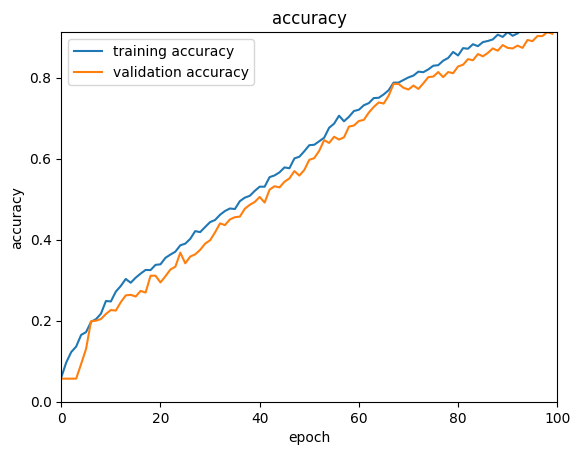

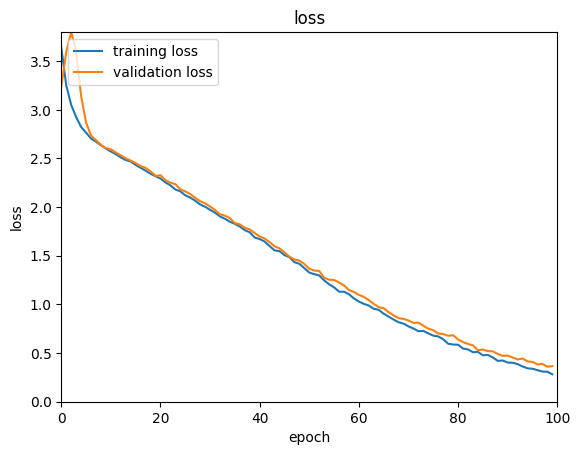

In [29]:
model_101 = build_101(8, 100, 0.000002, 0)

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 3.6226 - accuracy: 0.0497
Epoch 1: val_accuracy improved from -inf to 0.05278, saving model to /kaggle/working/resnet50_180.h5
90/90 [==============================] - 52s 206ms/step - loss: 3.6226 - accuracy: 0.0497 - val_loss: 3.0783 - val_accuracy: 0.0528
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 3.3164 - accuracy: 0.0604
Epoch 2: val_accuracy improved from 0.05278 to 0.06250, saving model to /kaggle/working/resnet50_180.h5
90/90 [==============================] - 18s 196ms/step - loss: 3.3164 - accuracy: 0.0604 - val_loss: 3.2274 - val_accuracy: 0.0625
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 3.1066 - accuracy: 0.1014
Epoch 3: val_accuracy did not improve from 0.06250
90/90 [==============================] - 17s 182ms/step - loss: 3.1066 - accuracy: 0.1014 - val_loss: 3.3200 - val_accuracy: 0.0625
Epoch 4/100
90/90 [==============================] - ETA: 0s - 

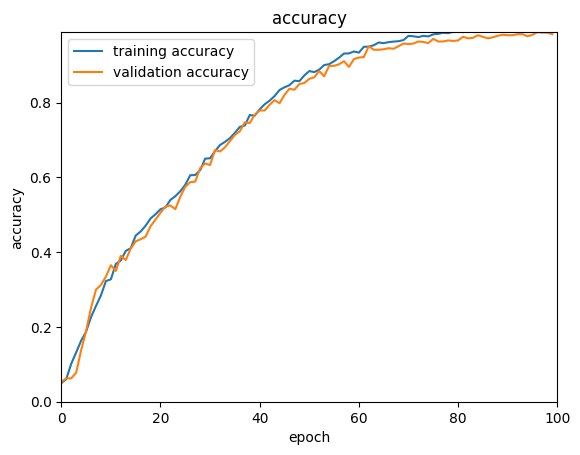

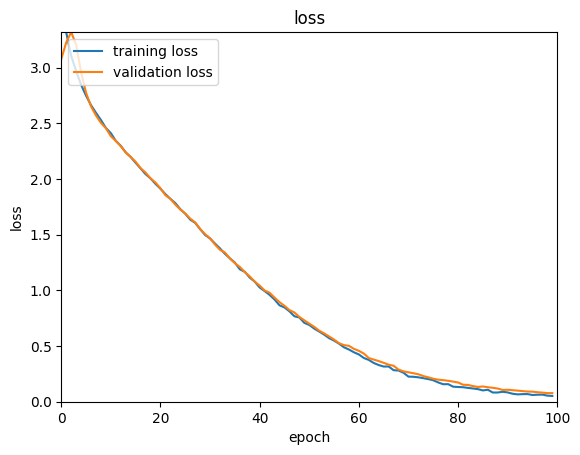

In [30]:
model_50 = build_50(8, 100, 0.0000015, 0)

In [31]:
resnet101 = keras.models.load_model(model_resnet101)
resnet50 = keras.models.load_model(model_resnet50)

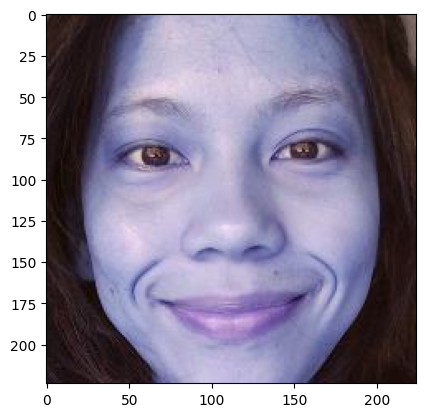

1/1 [==============================] - 1s 917ms/step
Nama File:  2117051009_IMG_20230930_121321_957.jpg
Prediksi 101:  2117051009
Probabilitas 101:  0.9772014617919922
Prediksi 50:  2117051009
Probabilitas 50:  0.9944741129875183




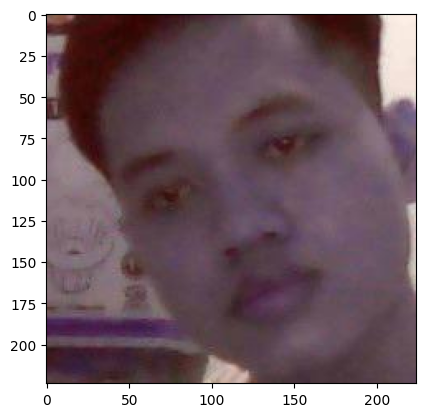

1/1 [==============================] - 0s 34ms/step
Nama File:  2157051001_WIN_20231002_21_48_54_Pro.jpg
Prediksi 101:  2157051001
Probabilitas 101:  0.8726159334182739
Prediksi 50:  2157051001
Probabilitas 50:  0.8663451671600342




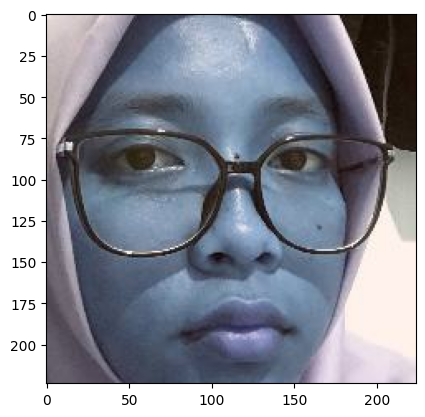

1/1 [==============================] - 0s 21ms/step
Nama File:  2117051095_IMG_9244.jpg
Prediksi 101:  2117051095
Probabilitas 101:  0.841326117515564
Prediksi 50:  2117051095
Probabilitas 50:  0.4949072003364563




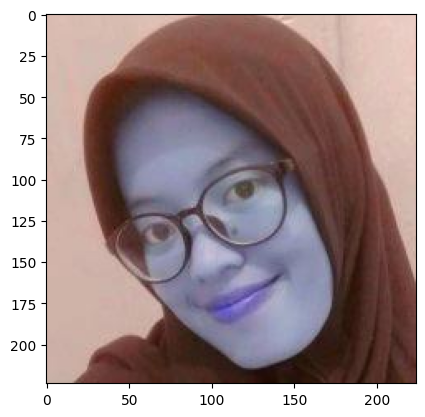

1/1 [==============================] - 0s 21ms/step
Nama File:  2117051068_IMG_20230504_183904_956-2.jpg
Prediksi 101:  2017051006
Probabilitas 101:  0.3758912980556488
Prediksi 50:  2017051006
Probabilitas 50:  0.3823450803756714




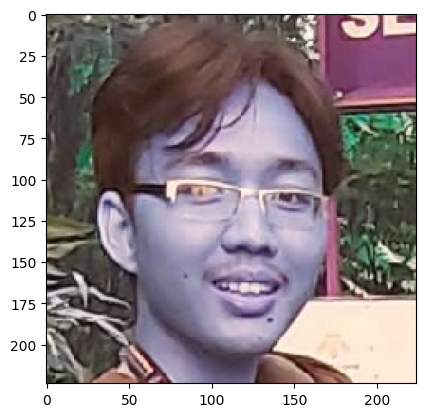

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051049_20220607_152943.jpg
Prediksi 101:  2017051049
Probabilitas 101:  0.5965038537979126
Prediksi 50:  2117051050
Probabilitas 50:  0.6770653128623962




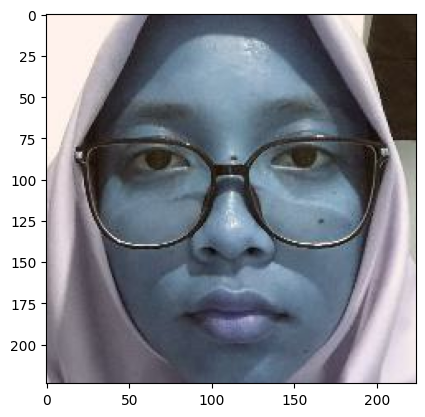

1/1 [==============================] - 0s 21ms/step
Nama File:  2117051095_IMG_9242.jpg
Prediksi 101:  2117051095
Probabilitas 101:  0.7318112850189209
Prediksi 50:  2117051095
Probabilitas 50:  0.8892232179641724




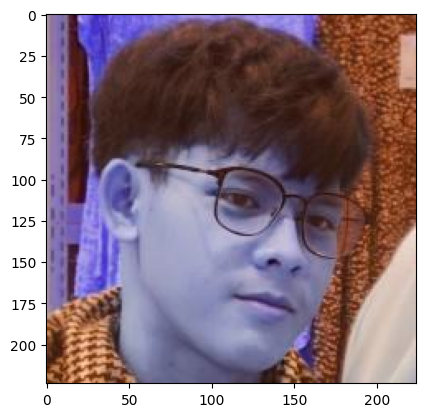

1/1 [==============================] - 0s 24ms/step
Nama File:  2017051061_IMG_3676.JPG
Prediksi 101:  2017051006
Probabilitas 101:  0.39248496294021606
Prediksi 50:  2017051078
Probabilitas 50:  0.394941508769989




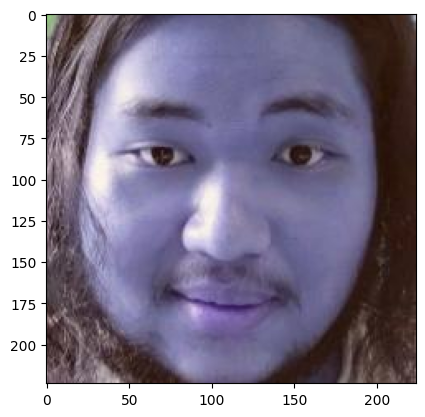

1/1 [==============================] - 0s 23ms/step
Nama File:  2007051040_IMG-20231116-WA0014.jpg
Prediksi 101:  2117051043
Probabilitas 101:  0.3659614026546478
Prediksi 50:  2117051009
Probabilitas 50:  0.41989487409591675




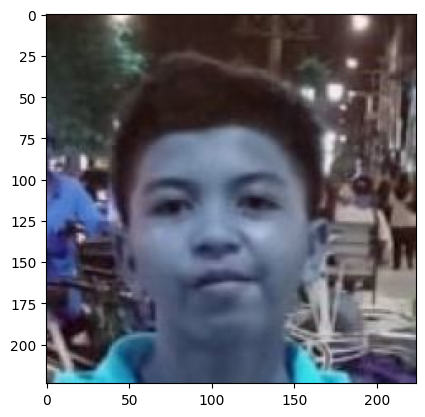

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051006_IMG-20190615-WA0010.jpg
Prediksi 101:  2017051006
Probabilitas 101:  0.35406816005706787
Prediksi 50:  2117051070
Probabilitas 50:  0.6661254167556763




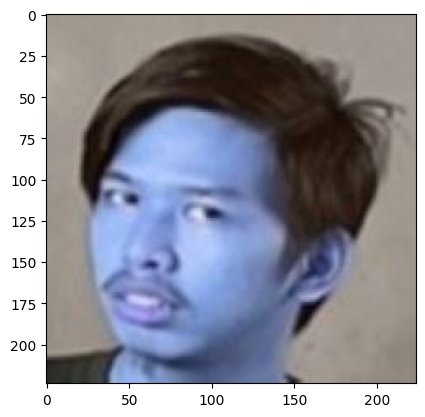

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051055_IMG-20230122-WA0039.jpg
Prediksi 101:  2017051055
Probabilitas 101:  0.9216166138648987
Prediksi 50:  2017051055
Probabilitas 50:  0.9903132915496826




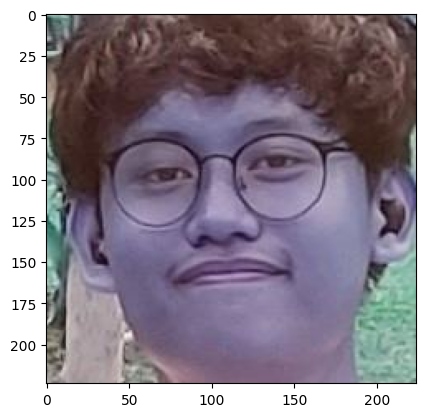

1/1 [==============================] - 0s 20ms/step
Nama File:  2117051070_IMG_20230509_104511.jpg
Prediksi 101:  2117051048
Probabilitas 101:  0.4806574583053589
Prediksi 50:  2117051048
Probabilitas 50:  0.6536726951599121




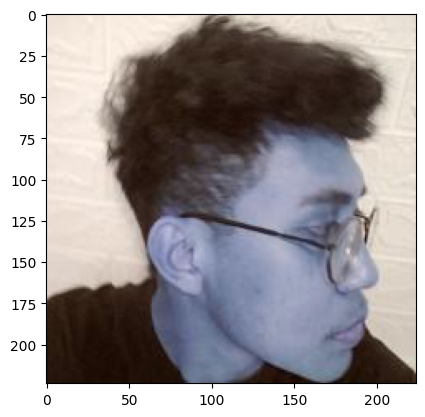

1/1 [==============================] - 0s 20ms/step
Nama File:  2117051019_IMG20231001213532.jpg
Prediksi 101:  2117051019
Probabilitas 101:  0.9100154638290405
Prediksi 50:  2117051019
Probabilitas 50:  0.7499018907546997




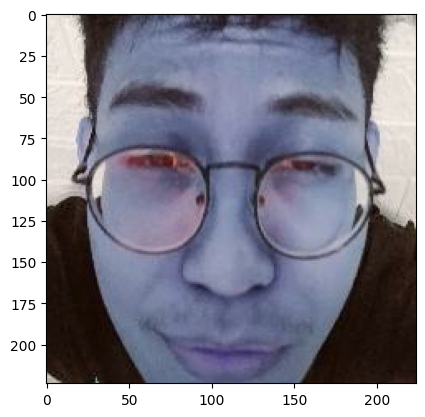

1/1 [==============================] - 0s 21ms/step
Nama File:  2117051019_IMG20231001213551.jpg
Prediksi 101:  2007051040
Probabilitas 101:  0.302547812461853
Prediksi 50:  2117051019
Probabilitas 50:  0.5059533715248108




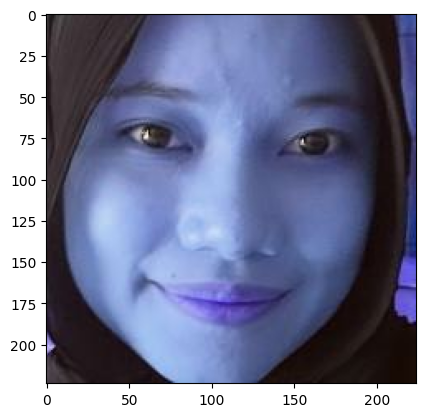

1/1 [==============================] - 0s 24ms/step
Nama File:  2017051051_F03EFA3D-BEDC-4D24-B2E1-D5138EAB9A64.jpg
Prediksi 101:  2117051009
Probabilitas 101:  0.39984050393104553
Prediksi 50:  unknown
Probabilitas 50:  0.2699539065361023




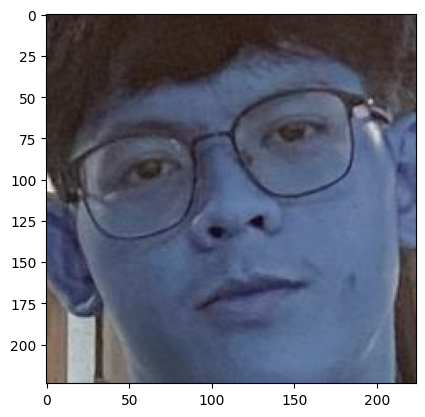

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051061_IMG_8097.jpg
Prediksi 101:  2017051006
Probabilitas 101:  0.3942222595214844
Prediksi 50:  2017051006
Probabilitas 50:  0.4736541211605072




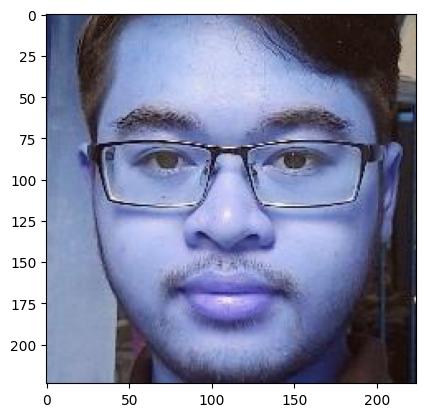

1/1 [==============================] - 0s 23ms/step
Nama File:  2117051050_20220127_142958.jpg
Prediksi 101:  2117051050
Probabilitas 101:  0.8112250566482544
Prediksi 50:  2007051040
Probabilitas 50:  0.4896516799926758




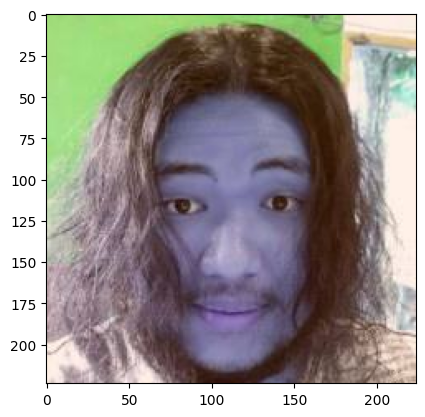

1/1 [==============================] - 0s 21ms/step
Nama File:  2007051040_IMG-20231116-WA0016.jpg
Prediksi 101:  2117051070
Probabilitas 101:  0.35176602005958557
Prediksi 50:  2017051017
Probabilitas 50:  0.6223625540733337




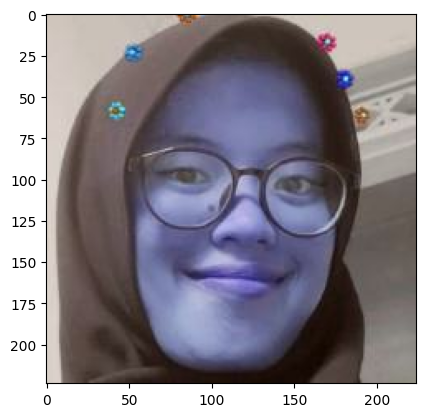

1/1 [==============================] - 0s 20ms/step
Nama File:  2117051068_IMG_20231122_151832_169.jpg
Prediksi 101:  unknown
Probabilitas 101:  0.22665001451969147
Prediksi 50:  2017051006
Probabilitas 50:  0.3789515495300293




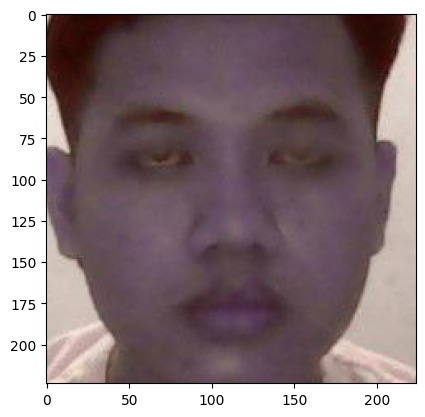

1/1 [==============================] - 0s 21ms/step
Nama File:  2157051001_WIN_20231002_21_48_30_Pro (2).jpg
Prediksi 101:  2157051001
Probabilitas 101:  0.9984257221221924
Prediksi 50:  2157051001
Probabilitas 50:  0.9995310306549072




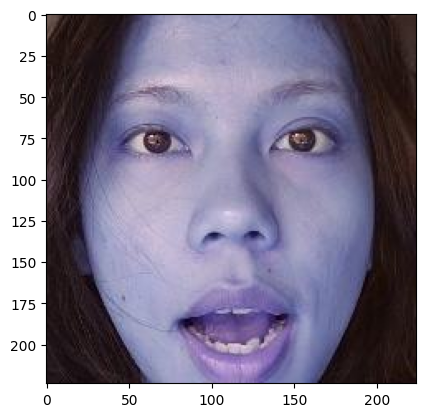

1/1 [==============================] - 0s 20ms/step
Nama File:  2117051009_IMG_20230930_121335_669.jpg
Prediksi 101:  2117051009
Probabilitas 101:  0.9278184771537781
Prediksi 50:  2117051009
Probabilitas 50:  0.992701530456543




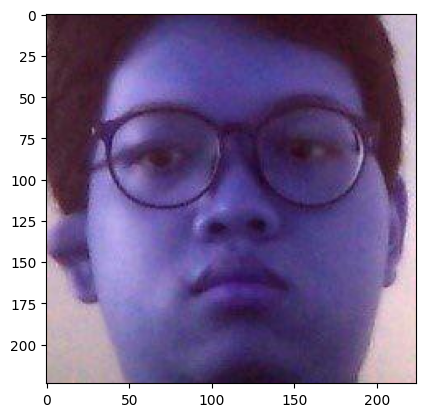

1/1 [==============================] - 0s 22ms/step
Nama File:  2117051048_WIN_20231003_13_41_33_Pro.jpg
Prediksi 101:  2117051048
Probabilitas 101:  0.7421349287033081
Prediksi 50:  2117051048
Probabilitas 50:  0.9765149354934692




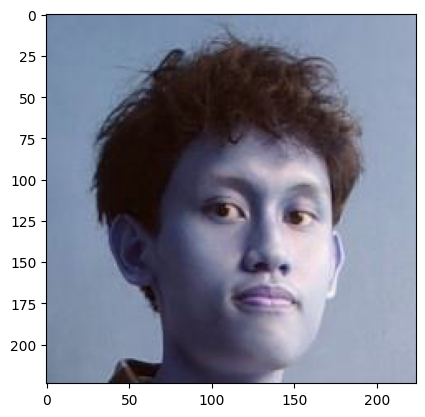

1/1 [==============================] - 0s 21ms/step
Nama File:  2117051070_IMG_20210726_114333.jpg
Prediksi 101:  2017051055
Probabilitas 101:  0.4577540159225464
Prediksi 50:  2017051061
Probabilitas 50:  0.4959142506122589




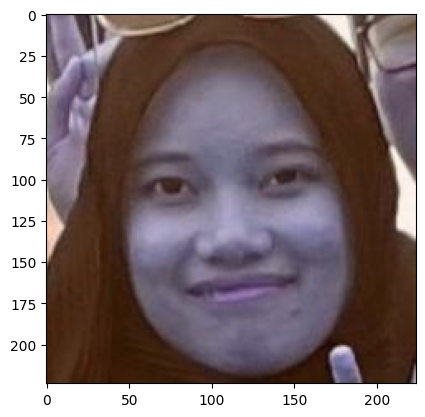

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051051_IMG-20231211-WA0013.jpg
Prediksi 101:  2017051006
Probabilitas 101:  0.9032800197601318
Prediksi 50:  2017051006
Probabilitas 50:  0.6806443333625793




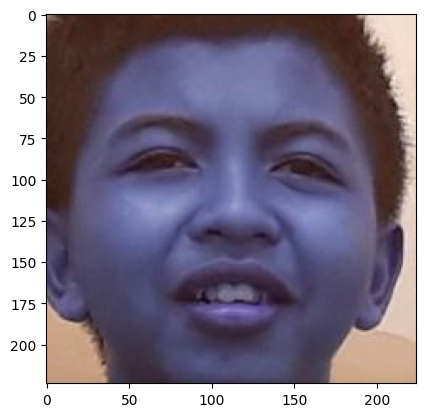

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051006_20200202_135118.jpg
Prediksi 101:  2117051048
Probabilitas 101:  0.4161876440048218
Prediksi 50:  2007051040
Probabilitas 50:  0.356770783662796




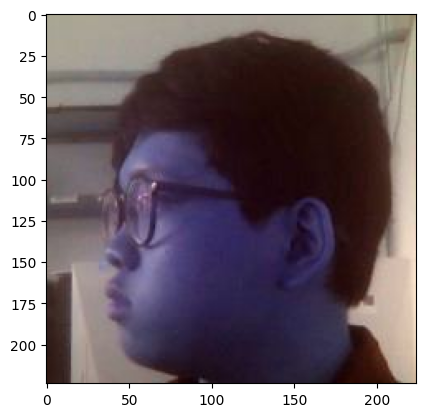

1/1 [==============================] - 0s 21ms/step
Nama File:  2117051048_WIN_20231003_13_43_48_Pro.jpg
Prediksi 101:  2117051048
Probabilitas 101:  0.9982377290725708
Prediksi 50:  2117051048
Probabilitas 50:  0.9999027252197266




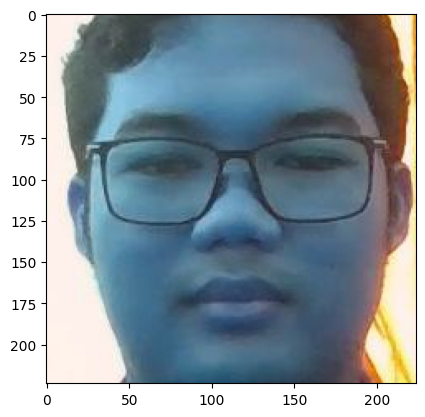

1/1 [==============================] - 0s 29ms/step
Nama File:  2017051001_WIN_20231113_09_22_37_Pro.jpg
Prediksi 101:  2017051001
Probabilitas 101:  0.9910592436790466
Prediksi 50:  2017051001
Probabilitas 50:  0.9953889846801758




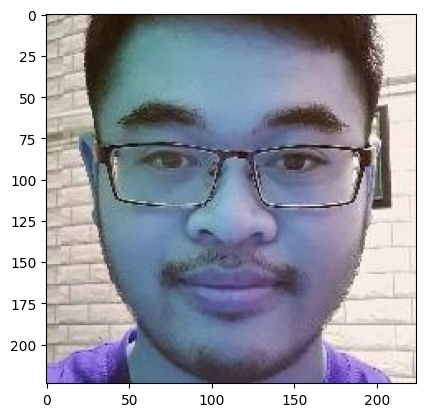

1/1 [==============================] - 0s 23ms/step
Nama File:  2117051050_20211203_234224.jpg
Prediksi 101:  2117051019
Probabilitas 101:  0.9195509552955627
Prediksi 50:  2117051019
Probabilitas 50:  0.8939817547798157




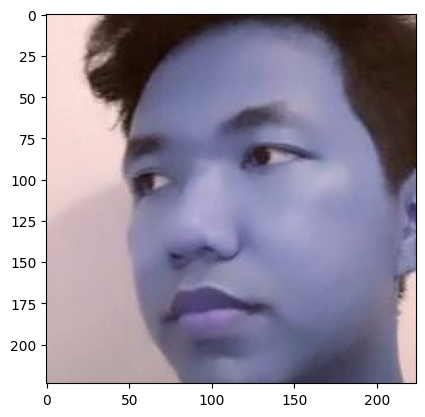

1/1 [==============================] - 0s 20ms/step
Nama File:  2117051027_IMG_20231001_202451_738.jpg
Prediksi 101:  2117051027
Probabilitas 101:  0.9862380027770996
Prediksi 50:  2117051027
Probabilitas 50:  0.9990542531013489




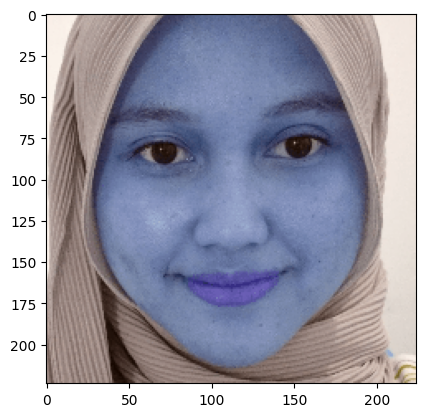

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051017_IMG_20230413_095038_889.png
Prediksi 101:  2117051070
Probabilitas 101:  0.6871315240859985
Prediksi 50:  2007051040
Probabilitas 50:  0.35487329959869385




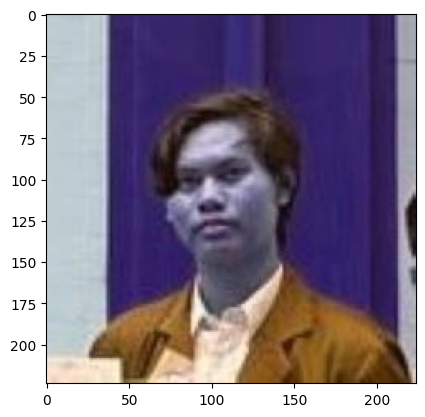

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051078_IMG-20230904-WA0001.jpg
Prediksi 101:  2017051078
Probabilitas 101:  0.9951493144035339
Prediksi 50:  2017051078
Probabilitas 50:  0.9949637651443481




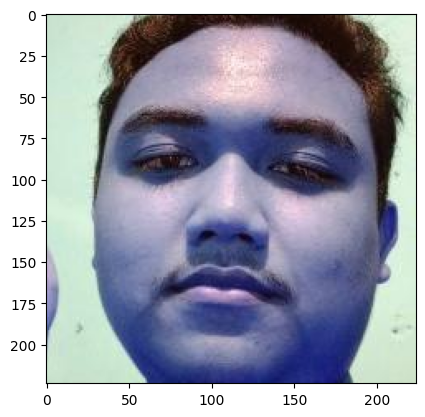

1/1 [==============================] - 0s 21ms/step
Nama File:  2157051006_2157051006_Muhammad Fadhilah Ramadhani_19.jpg
Prediksi 101:  2157051006
Probabilitas 101:  0.4845862090587616
Prediksi 50:  2157051006
Probabilitas 50:  0.5094755291938782




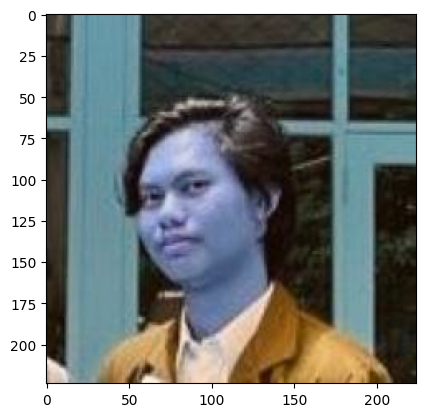

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051078_IMG-20230904-WA0006.jpg
Prediksi 101:  2017051078
Probabilitas 101:  0.9145289063453674
Prediksi 50:  2017051078
Probabilitas 50:  0.9531093239784241




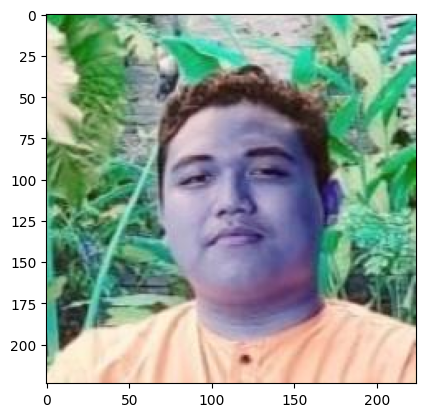

1/1 [==============================] - 0s 20ms/step
Nama File:  2157051006_2157051006_Muhammad Fadhilah Ramadhani_4.jpg
Prediksi 101:  2017051061
Probabilitas 101:  0.45600470900535583
Prediksi 50:  2017051078
Probabilitas 50:  0.42248812317848206




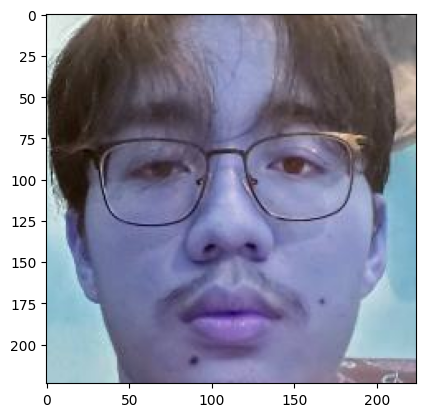

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051049_20220918_220925.jpg
Prediksi 101:  unknown
Probabilitas 101:  0.23189811408519745
Prediksi 50:  2007051040
Probabilitas 50:  0.3394390046596527




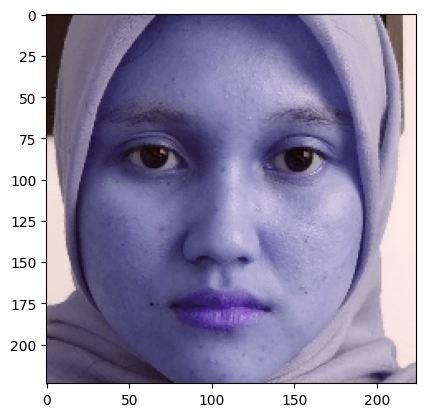

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051017_20230329_153813.png
Prediksi 101:  2017051017
Probabilitas 101:  0.418988436460495
Prediksi 50:  2017051017
Probabilitas 50:  0.7438056468963623




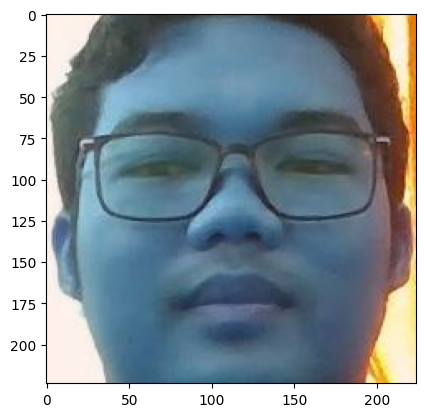

1/1 [==============================] - 0s 24ms/step
Nama File:  2017051001_WIN_20231113_09_22_33_Pro.jpg
Prediksi 101:  2017051001
Probabilitas 101:  0.9799484014511108
Prediksi 50:  2017051001
Probabilitas 50:  0.9940552711486816




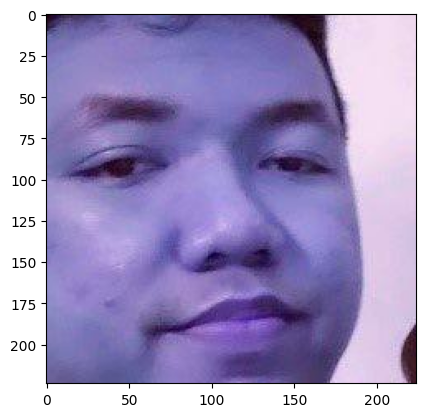

1/1 [==============================] - 0s 24ms/step
Nama File:  2117051027_IMG_20230503_102703_017.jpg
Prediksi 101:  2157051006
Probabilitas 101:  0.3677763342857361
Prediksi 50:  2007051040
Probabilitas 50:  0.3286973237991333




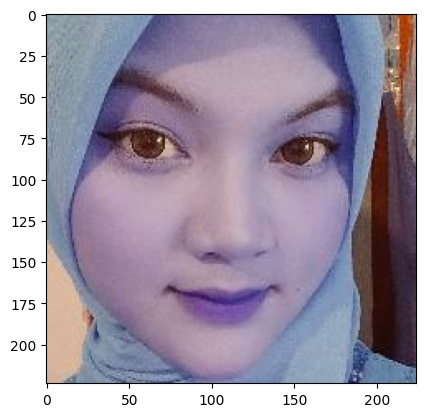

1/1 [==============================] - 0s 22ms/step
Nama File:  2117051043_IMG_20231003_133143.jpg
Prediksi 101:  2117051068
Probabilitas 101:  0.7825698256492615
Prediksi 50:  2117051068
Probabilitas 50:  0.5790731906890869




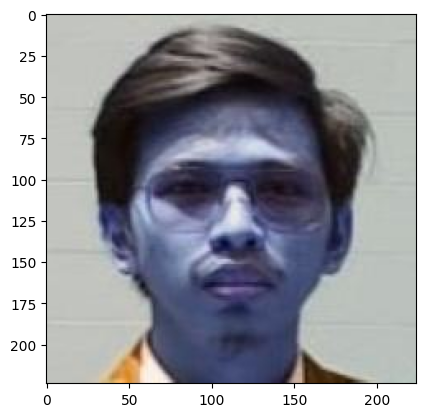

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051055_IMG-20230906-WA0007.jpg
Prediksi 101:  2017051055
Probabilitas 101:  0.7771443724632263
Prediksi 50:  2017051055
Probabilitas 50:  0.8461154699325562




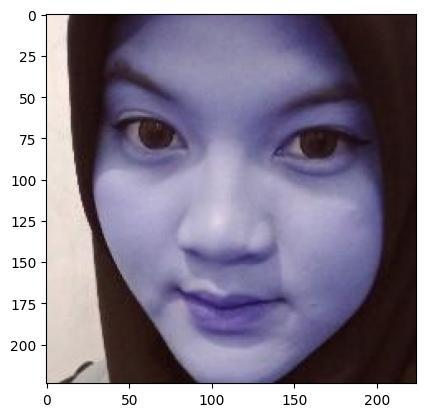

1/1 [==============================] - 0s 20ms/step
Nama File:  2117051043_IMG_20231003_131845.jpg
Prediksi 101:  2117051043
Probabilitas 101:  0.9629465937614441
Prediksi 50:  2117051043
Probabilitas 50:  0.5231087803840637


Jumlah prediksi benar 101:  22
Jumlah prediksi benar 50:  20


In [32]:
labels = train_gen.class_names
count_true_50 = 0
count_false_50 = 0
count_true_101 = 0
count_false_101 = 0
for image in os.listdir(testing_path):
  fact = image.split('_')[0]
  
  image_path = os.path.join(testing_path, image)

  img = load_img(image_path, target_size=(224,224))


  # tf.keras.applications.resnetS.preprocess_input(img)


  plt.imshow(img)
  plt.show()

  X = img_to_array(img)
  
  X = np.expand_dims(X, axis=0)

  images = np.vstack([X])

  predict_resnet101 = resnet101.predict(images)
  predict_resnet50 = resnet50.predict(images)

  predicted_class_resnet101 = np.argmax(predict_resnet101, axis=1)[0]
  predicted_class_resnet50 = np.argmax(predict_resnet50, axis=1)[0]
  
  confidential101 = max(predict_resnet101.tolist()[0])
  confidential50 = max(predict_resnet50.tolist()[0])

  if(confidential101 <= 0.3):
    predictions_resnet101 = 'unknown'
  else:
    predictions_resnet101 = labels[predicted_class_resnet101]
        
  if(confidential50 <= 0.3):
    predictions_resnet50 = 'unknown'
  else:
    predictions_resnet50 = labels[predicted_class_resnet50]
    
  if predictions_resnet101 == fact :
    count_true_101 += 1
  else:
    count_false_101 += 1
    
  if predictions_resnet50 == fact :
    count_true_50 += 1
  else:
    count_false_50 += 1
    
  print('Nama File: ', image)
  print('Prediksi 101: ', predictions_resnet101)
  print('Probabilitas 101: ', confidential101)
  print('Prediksi 50: ', predictions_resnet50)
  print('Probabilitas 50: ', confidential50)
  
  print('\n')
print("Jumlah prediksi benar 101: ", count_true_101)
print("Jumlah prediksi benar 50: ", count_true_50)

In [33]:
# model_pretrained = tf.keras.applications.resnet50.ResNet50(include_top=True,
#                  weights=None,
#                  input_shape=(224, 224, 3),
#                  pooling=max,
#                  classes=20)
# model_pretrained.summary()

In [34]:
# model_pretrained.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
# history = model_pretrained.fit(
#       train_gen,
#       epochs=100,
#       validation_data=validate_gen,
#       batch_size=8,
#     )

In [35]:
# print_history(history, 100)